##  Imports 

In [1]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


##  1. CSV setup 

In [13]:
# 📂 Step 1: Load your raw sensor CSV (replace if needed)
train_path = '../test_csv/normal_2.csv'  # <-- UPDATE THIS PATH if needed
test_path = '../test_csv/motor_temp_low.csv'  # <-- UPDATE THIS PATH if needed

# 1️⃣ Load the raw file
df_train_raw = pd.read_csv(train_path)
df_test_raw = pd.read_csv(test_path)

# 2️⃣ Convert timestamps properly
df_train_raw['timestamp'] = pd.to_datetime(df_train_raw['timestamp'])
df_test_raw['timestamp'] = pd.to_datetime(df_test_raw['timestamp'])

# 3️⃣ Lock the row index for later tracing
df_train_raw['csv_index'] = df_train_raw.index
df_test_raw['csv_index'] = df_test_raw.index

# # 4️⃣ Print preview to confirm it's working
# print("📋 First 5 rows of raw CSV:")
# print(df_train_raw.head())

# # 5️⃣ Confirm the index alignment is safe
# index_check = all(df_train_raw['csv_index'] == df_train_raw.index)
# print(f"\n✅ csv_index aligned with DataFrame index? {index_check}")

## 2. Group by states

In [ ]:
# 📂 Step 2: Group multivariate data by state

# 1️⃣ Drop missing rows
df_train_clean = df_train_raw.dropna()
df_test_clean = df_test_raw.dropna()

# 2️⃣ Pivot data so each timestamp has all sensor readings as columns
df_train_pivot = df_train_clean.pivot(index="timestamp", columns="sensor", values="feature_0")
df_test_pivot = df_test_clean.pivot(index="timestamp", columns="sensor", values="feature_0")

# 3️⃣ Add state back to the pivoted data
# We'll assume each timestamp has only one state (i.e., consistent across sensors)
# So we extract state per timestamp by taking the first occurrence
state_map_train = df_train_clean.groupby("timestamp")["state"].first()
state_map_test = df_test_clean.groupby("timestamp")["state"].first()

# Merge state into pivoted data
df_train_pivot["state"] = state_map_train
df_test_pivot["state"] = state_map_test

# 4️⃣ Check available states in multivariate format
print("📊 Unique states in multivariate training data:")
print(df_train_pivot["state"].value_counts())
print(df_train_pivot.head())


📊 Unique states in multivariate training data:
state
run     35520
off      4500
idle     3150
Name: count, dtype: int64
sensor                  power       rpm  temperature  vibration state
timestamp                                                            
2025-04-07 00:00:00  4.626855  2.355440         22.0   7.854178   off
2025-04-07 00:01:00  4.136541  2.328874         22.0   7.535466   off
2025-04-07 00:02:00  5.120662  2.358879         22.0   7.746224   off
2025-04-07 00:03:00  4.400668  2.600601         22.0   7.582647   off
2025-04-07 00:04:00  4.868998  2.469488         22.0   7.469315   off


In [ ]:
# 📂 Step 3: Normalize + sequence generation for 'run' state only (test)

# Select 'run' state group
run_df_train = df_train_pivot[df_train_pivot["state"] == "run"].drop(columns=["state"])
run_df_test = df_test_pivot[df_test_pivot["state"] == "run"].drop(columns=["state"])

# Normalize the feature_0 column
scaler = MinMaxScaler()
run_scaled_train = scaler.fit_transform(run_df_train)
run_scaled_test = scaler.transform(run_df_test)

def create_sequences_multivariate(data, window=20):
    sequences = []
    for i in range(len(data) - window + 1):
        seq = data[i:i+window]
        sequences.append(seq)
    return np.array(sequences)

# Generate sequences
seq_len = 20
X = create_sequences_multivariate(run_scaled_train, window=seq_len)
Y = create_sequences_multivariate(run_scaled_test, window=seq_len)

In [21]:
# Parameters
seq_len = 20
batch_size = 128
epochs = 10
state_models = {}


In [23]:

# Function to create sequences
def create_sequences_multivariate(data, window=20):
    return np.array([data[i:i+window] for i in range(len(data) - window + 1)])

    
df_train_pivot_clean = df_train_pivot.dropna()
for state_name, group_df in df_train_pivot_clean.groupby("state"):
    print(f"\n🔧 Training model for state: {state_name}")

    # Drop 'state' column to isolate feature data
    group_features = group_df.drop(columns=["state"])

    # Normalize
    scaler = MinMaxScaler()
    group_scaled = scaler.fit_transform(group_features)

    # Sequence generation
    X_state = create_sequences_multivariate(group_scaled, window=seq_len)

    # Build model
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(X_state.shape[1], X_state.shape[2]), return_sequences=False),
        RepeatVector(X_state.shape[1]),
        LSTM(64, activation='relu', return_sequences=True),
        TimeDistributed(Dense(X_state.shape[2]))
    ])
    model.compile(optimizer=Adam(1e-3), loss='mse')

    # Train
    model.fit(X_state, X_state, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

    # Save model and scaler
    state_models[state_name] = {
        "model": model,
        "scaler": scaler
    }



🔧 Training model for state: idle
Epoch 1/10


g:\Conda\envs\python3.12\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1480 - val_loss: 0.0372
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0370 - val_loss: 0.0299
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0283 - val_loss: 0.0245
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0232 - val_loss: 0.0201
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0195 - val_loss: 0.0175
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0173 - val_loss: 0.0167
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0168 - val_loss: 0.0165
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0166 - val_loss: 0.0164
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0166 - val_loss: 0.0164
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0164 - val_loss: 0.0162

🔧 Training model for state: off
Epoch 1/10


g:\Conda\envs\python3.12\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1389 - val_loss: 0.0297
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0255 - val_loss: 0.0207
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0194 - val_loss: 0.0163
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0155 - val_loss: 0.0137
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0132 - val_loss: 0.0124
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0121 - val_loss: 0.0120
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0118 - val_loss: 0.0119
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0116 - val_loss: 0.0117
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0115 - val_loss: 0.0116
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0114 - val_loss: 0.0113

🔧 Training model for state: run
Epoch 1/10


g:\Conda\envs\python3.12\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0704 - val_loss: 0.0076
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 4/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 5/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 6/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0066 - val_loss: 0.0067
Epoch 7/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0066 - val_loss: 0.0067
Epoch 8/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0066 - val_loss: 0.0068
Epoch 9/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0065 - val_loss: 0.0066


In [24]:
all_results = []

seq_len = 20

def create_sequences_multivariate(data, window=20):
    return np.array([data[i:i+window] for i in range(len(data) - window + 1)])

# 1. Loop over each state in the test data
for state, group_df in df_test_pivot.dropna().groupby("state"):
    print(f"\n📌 Predicting for state: {state}")

    if state not in state_models:
        print(f"⚠️ Skipping state '{state}' — no trained model available.")
        continue

    model = state_models[state]["model"]
    scaler = state_models[state]["scaler"]

    # Drop state column to get features only
    X_test_state = group_df.drop(columns=["state"])

    # Normalize
    X_scaled = scaler.transform(X_test_state)

    # Sequence creation
    Y_state = create_sequences_multivariate(X_scaled, window=seq_len)

    # Predict
    Y_pred = model.predict(Y_state)
    errors = np.mean(np.abs(Y_pred - Y_state), axis=(1, 2))

    # Mode-based threshold
    hist, bin_edges = np.histogram(errors, bins=100)
    mode_index = np.argmax(hist)
    threshold = bin_edges[mode_index] * 1.5 # Adjust threshold as needed
    print(f"📊 Mode threshold for state '{state}': {threshold:.6f}")

    # Label anomalies
    is_anomaly = (errors > threshold).astype(int)

    # Map timestamps
    timestamps = group_df.index[seq_len - 1:]  # align with sequence ends

    # Store results
    result_df = pd.DataFrame({
        "timestamp": timestamps,
        "state": state,
        "reconstruction_error": errors,
        "threshold": threshold,
        "is_anomaly": is_anomaly
    })

    all_results.append(result_df)

# 2. Combine all state-specific results
final_results = pd.concat(all_results).sort_values("timestamp").reset_index(drop=True)


📌 Predicting for state: idle
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
📊 Mode threshold for state 'idle': 0.132372

📌 Predicting for state: off
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/stepWARNING:tensorflow:5 out of the last 83 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002352A348040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
📊 Mode threshold for state 'off': 0.104738

📌 Predictin

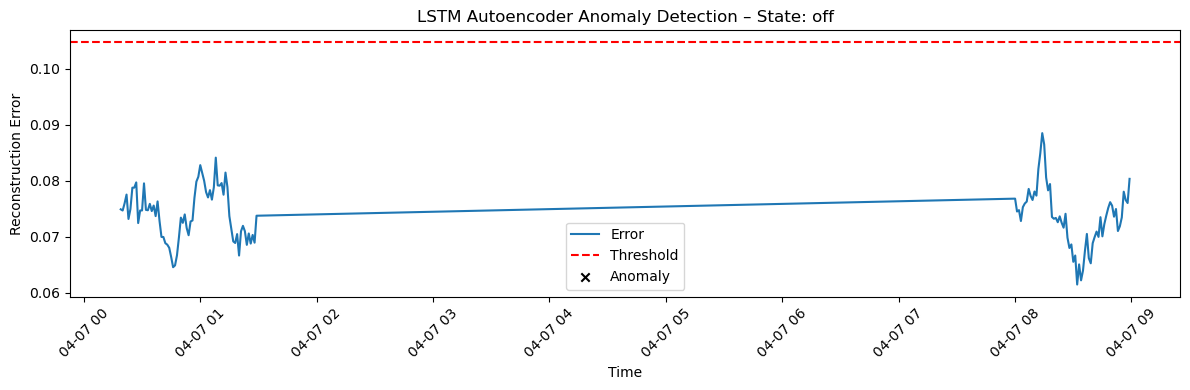

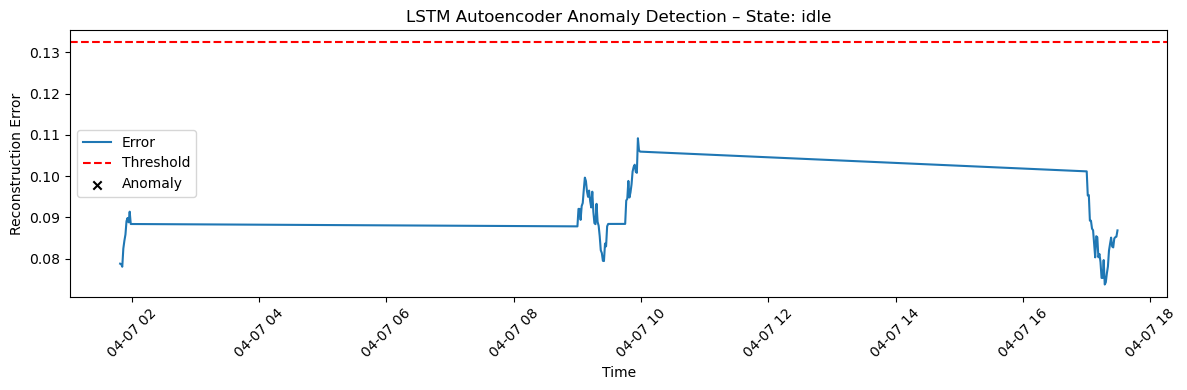

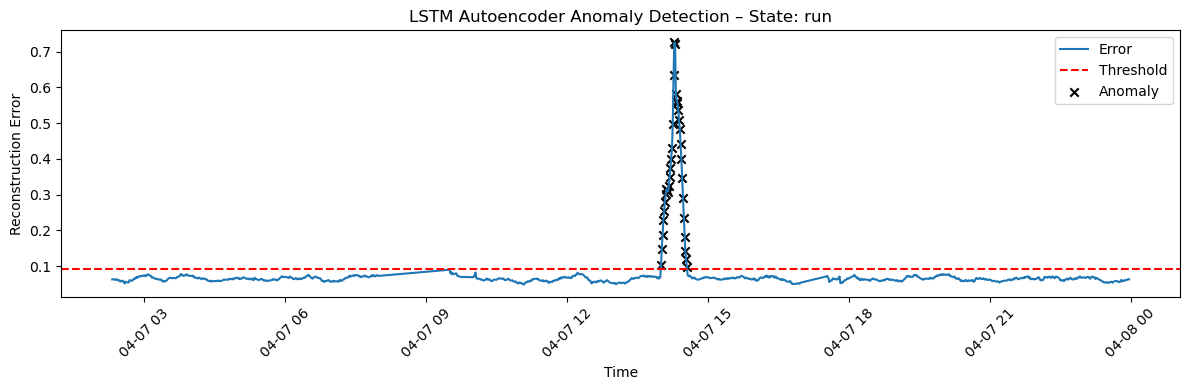

In [25]:
for state in final_results["state"].unique():
    subset = final_results[final_results["state"] == state]
    plt.figure(figsize=(12, 4))
    plt.plot(subset["timestamp"], subset["reconstruction_error"], label="Error")
    plt.axhline(y=subset["threshold"].iloc[0], color='red', linestyle='--', label="Threshold")
    plt.scatter(
        subset["timestamp"][subset["is_anomaly"] == 1],
        subset["reconstruction_error"][subset["is_anomaly"] == 1],
        color='black', marker='x', label='Anomaly'
    )
    plt.title(f"LSTM Autoencoder Anomaly Detection – State: {state}")
    plt.xlabel("Time")
    plt.ylabel("Reconstruction Error")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
# 📂 Stage 3: Filter out anomalies during state transitions

# 1️⃣ Set how many rows before/after a transition to flag
transition_window = 3

# 2️⃣ Re-merge run_results_df with all other states (if needed later)
transition_df = run_results_df.copy().reset_index(drop=True)
transition_df['is_transition'] = 0

# 3️⃣ Flag transitions (basic logic here assumes one state only, later we’ll do multi-state logic)
for i in range(1, len(transition_df)):
    if transition_df.loc[i, 'start_csv_index'] - transition_df.loc[i-1, 'end_csv_index'] > 1:
        for j in range(i - transition_window, i + transition_window + 1):
            if 0 <= j < len(transition_df):
                transition_df.loc[j, 'is_transition'] = 1

# 4️⃣ Final filtered anomalies
final_anomalies_df = transition_df[
    (transition_df['is_anomaly'] == 1) & (transition_df['is_transition'] == 0)
]

# 5️⃣ Show sample
print(f"✅ Final anomaly count (after transition filter): {len(final_anomalies_df)}")
display(final_anomalies_df.head(10))


✅ Final anomaly count (after transition filter): 12


,start_csv_index,end_csv_index,timestamp,state,reconstruction_error,is_anomaly,is_transition
132,1318,1337,2025-04-07 22:17:00,run,0.025234,1,0
135,1321,1340,2025-04-07 22:20:00,run,0.025446,1,0
136,1322,1341,2025-04-07 22:21:00,run,0.025083,1,0
137,1323,1342,2025-04-07 22:22:00,run,0.024974,1,0
140,1326,1345,2025-04-07 22:25:00,run,0.025014,1,0
210,1396,1415,2025-04-07 23:35:00,run,0.025721,1,0
219,1405,1424,2025-04-07 23:44:00,run,0.025286,1,0
220,1406,1425,2025-04-07 23:45:00,run,0.026570,1,0
221,1407,1426,2025-04-07 23:46:00,run,0.025639,1,0
224,1410,1429,2025-04-07 23:49:00,run,0.025808,1,0
